# Generalizing a Taylor Recurrence

In [1]:
from sumpy.recurrence import _make_sympy_vec, get_processed_and_shifted_recurrence

from sumpy.expansion.diff_op import (
    laplacian,
    make_identity_diff_op,
)

from sumpy.recurrence import get_recurrence, recurrence_from_pde, shift_recurrence, get_shifted_recurrence_exp_from_pde, _extract_idx_terms_from_recurrence

import sympy as sp
from sympy import hankel1

import numpy as np

import math

import matplotlib.pyplot as plt
from matplotlib import cm, ticker

In [2]:
var = _make_sympy_vec("x", 2)
s = sp.Function("s")
n = sp.symbols("n")
i = sp.symbols("i")

In [3]:
w = make_identity_diff_op(2)
laplace2d = laplacian(w)

w = make_identity_diff_op(2)
helmholtz2d = laplacian(w) + w

In [4]:
def compute_derivatives(p):
    var = _make_sympy_vec("x", 2)
    var_t = _make_sympy_vec("t", 2)
    g_x_y = sp.log(sp.sqrt((var[0]-var_t[0])**2 + (var[1]-var_t[1])**2))
    derivs = [sp.diff(g_x_y,
                        var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                        for i in range(p)]
    return derivs

In [5]:
def compute_derivatives_h2d(p, k=1.0):
    var = _make_sympy_vec("x", 2)
    var_t = _make_sympy_vec("t", 2)
    abs_dist = sp.sqrt((var[0]-var_t[0])**2 +
                        (var[1]-var_t[1])**2)
    g_x_y = (1j/4) * hankel1(0, k * abs_dist)
    derivs_helmholtz = [sp.diff(g_x_y,
                        var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                                                for i in range(p)]
    return derivs_helmholtz

# Step 1: Get recurrence as expression that evaluates to 0 and sanity check it

In [6]:
recur_lap, order_lap = get_shifted_recurrence_exp_from_pde(laplace2d)
order_lap

4

In [7]:
#Sanity check that recurrence is correct
derivs_lap = compute_derivatives(15)
exp = recur_lap.subs(n, 4)
exp.subs(s(4), derivs_lap[4]).subs(s(3), derivs_lap[3]).subs(s(2), derivs_lap[2]).subs(s(1), derivs_lap[1]).subs(var[0],np.random.rand()).subs(var[1],np.random.rand())

-5.55805401702969e-15

## Step 2: After performing a Taylor expansion of the $s(n), s(n-1), \dots$ in the 1D recurrence we need to create a 2D grid of coefficients 
$$
grid[i, j]
$$
Where $i = 0$ represents the coefficient attached to $s(n)$ and $i = 1$ represents $s(n-1)$, etc. and the $j$ is for the polynomial in $x_0$.

In [8]:
def get_grid(recur, order):
    poly_in_s_n = sp.poly(recur, [s(n-i) for i in range(order)])
    coeff_s_n = [poly_in_s_n.coeff_monomial(poly_in_s_n.gens[i]) for i in range(order)]

    table = []
    for i in range(len(coeff_s_n)):
        table.append(sp.poly(coeff_s_n[i], var[0]).all_coeffs()[::-1])

    return table

In [9]:
grid = get_grid(recur_lap, order_lap)
grid

[[0, (-1)**n*x1**2, 0, (-1)**n],
 [-(-1)**n*n*x1**2 + 3*(-1)**n*x1**2, 0, -3*(-1)**n*n + 5*(-1)**n],
 [0, 3*(-1)**n*n**2 - 13*(-1)**n*n + 14*(-1)**n],
 [-(-1)**n*n**3 + 8*(-1)**n*n**2 - 21*(-1)**n*n + 18*(-1)**n]]

# Step 3: Grid of Coefficient to Grid Recurrence
$$
f(x_1) x_0^k s(n-j) \to f(x_1) x_0^k \sum_{i=0}^{\infty} s_{n-j,i} \frac{x_0^i}{i!} = f(x_1) \sum_{i=k}^{\infty} s_{n-j,i-k} \frac{x_0^i}{(i-k)!} 
$$

In [10]:
def convert(grid):
    recur_exp = 0
    i = sp.symbols("i")
    s_terms = []
    for j in range(len(grid)):
        for k in range(len(grid[j])):
            recur_exp += grid[j][k] * s(n-j,i-k)/sp.factorial(i-k)
            if grid[j][k] != 0:
                s_terms.append((j,k))
    return recur_exp, s_terms
grid_recur, s_terms = convert(grid)
s_terms
grid_recur

(-1)**n*x1**2*s(n, i - 1)/factorial(i - 1) + (-1)**n*s(n, i - 3)/factorial(i - 3) + (-3*(-1)**n*n + 5*(-1)**n)*s(n - 1, i - 2)/factorial(i - 2) + (-(-1)**n*n*x1**2 + 3*(-1)**n*x1**2)*s(n - 1, i)/factorial(i) + (3*(-1)**n*n**2 - 13*(-1)**n*n + 14*(-1)**n)*s(n - 2, i - 1)/factorial(i - 1) + (-(-1)**n*n**3 + 8*(-1)**n*n**2 - 21*(-1)**n*n + 18*(-1)**n)*s(n - 3, i)/factorial(i)

# Step 4: Translate grid recurrence to column recurrence
We can use the fact
$$
s_{n, i} = s_{n-j, i+j} (-1)^j
$$
to perform the following translation:
$$
s_{x, i-l} \to s_{x+l, i} (-1)^l
$$

In [11]:
def grid_recur_to_column_recur(grid_recur, s_terms):
    grid_recur_simp = grid_recur
    bag = set()
    for s_t in s_terms:
        bag.add(-((0-s_t[0])-s_t[1]))
        grid_recur_simp = grid_recur_simp.subs(s(n-s_t[0],i-s_t[1]), (-1)**(s_t[1])*s((n-s_t[0])-s_t[1],(i-s_t[1])+s_t[1]))
    shift = min(bag)
    return sp.solve(sp.simplify(grid_recur_simp * sp.factorial(i)).subs(n, n+shift), s(n,i))[0]

In [12]:
column_recur = grid_recur_to_column_recur(grid_recur, s_terms)
column_recur

(-i**2 - 2*i*n + 3*i - n**2 + 3*n - 2)*s(n - 2, i)/x1**2

# Part 5: Package into Big Function:

In [13]:
def get_taylor_recurrence(pde):
    recur, order = get_shifted_recurrence_exp_from_pde(pde)
    grid = get_grid(recur, order)
    grid_recur, s_terms = convert(grid)
    column_recur = grid_recur_to_column_recur(grid_recur, s_terms)
    return column_recur

In [14]:
get_taylor_recurrence(laplace2d)

(-i**2 - 2*i*n + 3*i - n**2 + 3*n - 2)*s(n - 2, i)/x1**2

In [15]:
get_taylor_recurrence(helmholtz2d).subs(i, 2).subs(n, 3)

(-8*s(-1, 2) - 12*s(1, 2))/x1**2

# Part 6: Check Edge Cases for Grid Recurrence

## Laplace

In [16]:
width_lap_grid = 8
length_lap_grid = 8
true_grid_lap = [[sp.diff(derivs_lap[i], var[0], j).subs(var[0], 0) for j in range(width_lap_grid)] for i in range(length_lap_grid)]
true_grid_lap

[[log(sqrt(x1**2)), 0, x1**(-2), 0, -6/x1**4, 0, 120/x1**6, 0],
 [0, -1/x1**2, 0, 6/x1**4, 0, -120/x1**6, 0, 5040/x1**8],
 [x1**(-2), 0, -6/x1**4, 0, 120/x1**6, 0, -5040/x1**8, 0],
 [0, 6/x1**4, 0, -120/x1**6, 0, 5040/x1**8, 0, -362880/x1**10],
 [-6/x1**4, 0, 120/x1**6, 0, -5040/x1**8, 0, 362880/x1**10, 0],
 [0, -120/x1**6, 0, 5040/x1**8, 0, -362880/x1**10, 0, 39916800/x1**12],
 [120/x1**6, 0, -5040/x1**8, 0, 362880/x1**10, 0, -39916800/x1**12, 0],
 [0, 5040/x1**8, 0, -362880/x1**10, 0, 39916800/x1**12, 0, -6227020800/x1**14]]

In [71]:
def create_subs_grid(width, length, derivs, coord_dict):
    initial_grid = [[sp.diff(derivs[i], var[0], j).subs(var[0], 0) for j in range(width)] for i in range(length)]

    # assume len(initial_grid) >= 1
    initial_grid_subs = []
    initial_grid_width = len(initial_grid[0])
    initial_grid_length = len(initial_grid)
    coord_dict = {var[1]: 1}

    for i_x in range(initial_grid_length):
        tmp = []
        for j_x in range(initial_grid_width):
            tmp.append((initial_grid[i_x][j_x].subs(var[1],coord_dict[var[1]])).evalf())
        initial_grid_subs.append(tmp)
    
    return initial_grid_subs


In [72]:
coord_dict = {var[0]: 1e-1, var[1]: 1.2}
initial_grid_subs_laplace = create_subs_grid(6, 2, derivs_lap, coord_dict)
initial_grid_subs_laplace

[[0, 0, 1.00000000000000, 0, -6.00000000000000, 0],
 [0, -1.00000000000000, 0, 6.00000000000000, 0, -120.000000000000]]

### Package into Function

In [65]:
def extend_grid(initial_grid_in, grid_recur, coord_dict, n_derivs_compute, order_grid_recur):
    initial_grid_subs = [row[:] for row in initial_grid_in] #deep copy

    initial_grid_width = len(initial_grid_subs[0])
    initial_grid_length = len(initial_grid_subs)

    for n_x in range(initial_grid_length, n_derivs_compute):
        appMe = []
        for i_x in range(initial_grid_width):
            exp_i_n = grid_recur.subs(n, n_x).subs(i, i_x)
            if exp_i_n == 0:
                exp_i_n = sp.diff(derivs_lap[n_x], var[0], i_x).subs(var[0], 0)
            assert n_x-order_grid_recur >= 0
            kys = [s(n_x-k,i_x) for k in range(1,order_grid_recur+1)]
            vals = [initial_grid_subs[n_x-k][i_x] for k in range(1, order_grid_recur+1)]
            my_dict = dict(zip(kys, vals))
            res = exp_i_n.subs(my_dict).subs(coord_dict)
            appMe.append(res)

        initial_grid_subs.append(appMe)

    return initial_grid_subs


In [66]:
extend_grid(initial_grid_subs_laplace, get_taylor_recurrence(laplace2d), coord_dict, 8, 2)

[[0, 0, 1.00000000000000, 0, -6.00000000000000, 0],
 [0, -1.00000000000000, 0, 6.00000000000000, 0, -120.000000000000],
 [0.826446280991735, 0, -4.95867768595041, 0, 99.1735537190083, 0],
 [0, 4.95867768595041, 0, -99.1735537190083, 0, 4165.28925619835],
 [-4.09808073219042, 0, 81.9616146438085, 0, -3442.38781503996, 0],
 [0, -81.9616146438085, 0, 3442.38781503996, 0, -247851.922682877],
 [67.7368716064533, 0, -2844.94860747104, 0, 204836.299737915, 0],
 [0, 2844.94860747104, 0, -204836.299737915, 0, 22531992.9711706]]

In [68]:
create_subs_grid(6, 8, derivs_lap, coord_dict)

[[0, 0, 1.00000000000000, 0, -6.00000000000000, 0],
 [0, -1.00000000000000, 0, 6.00000000000000, 0, -120.000000000000],
 [1.00000000000000, 0, -6.00000000000000, 0, 120.000000000000, 0],
 [0, 6.00000000000000, 0, -120.000000000000, 0, 5040.00000000000],
 [-6.00000000000000, 0, 120.000000000000, 0, -5040.00000000000, 0],
 [0, -120.000000000000, 0, 5040.00000000000, 0, -362880.000000000],
 [120.000000000000, 0, -5040.00000000000, 0, 362880.000000000, 0],
 [0, 5040.00000000000, 0, -362880.000000000, 0, 39916800.0000000]]

## Helmholtz

In [21]:
derivs_helm = compute_derivatives_h2d(5)
width_helm_grid = 4
length_helm_grid = 4
true_grid_helm = [[sp.diff(derivs_helm[i], var[0], j).subs(var[0], 0) for j in range(width_helm_grid)] for i in range(length_helm_grid)]
true_grid_helm

[[0.25*I*hankel1(0, 1.0*sqrt(x1**2)),
  0,
  0.25*I*(0.5*hankel1(-1, 1.0*sqrt(x1**2)) - 0.5*hankel1(1, 1.0*sqrt(x1**2)))/sqrt(x1**2),
  0],
 [0,
  -0.25*I*(hankel1(-1, 1.0*sqrt(x1**2))/2 - hankel1(1, 1.0*sqrt(x1**2))/2)/sqrt(x1**2),
  0,
  I*(-(0.75*(0.25*hankel1(-2, 1.0*sqrt(x1**2)) - 0.25*hankel1(0, 1.0*sqrt(x1**2)))/sqrt(x1**2) - 0.75*(0.25*hankel1(0, 1.0*sqrt(x1**2)) - 0.25*hankel1(2, 1.0*sqrt(x1**2)))/sqrt(x1**2))/sqrt(x1**2) + 0.375*(hankel1(-1, 1.0*sqrt(x1**2)) - hankel1(1, 1.0*sqrt(x1**2)))/(x1**2)**(3/2))],
 [0.25*I*(0.5*hankel1(-1, 1.0*sqrt(x1**2)) - 0.5*hankel1(1, 1.0*sqrt(x1**2)))/sqrt(x1**2),
  0,
  0.25*I*(((0.25*hankel1(-2, 1.0*sqrt(x1**2)) - 0.25*hankel1(0, 1.0*sqrt(x1**2)))/sqrt(x1**2) - (0.25*hankel1(0, 1.0*sqrt(x1**2)) - 0.25*hankel1(2, 1.0*sqrt(x1**2)))/sqrt(x1**2))/sqrt(x1**2) - (0.5*hankel1(-1, 1.0*sqrt(x1**2)) - 0.5*hankel1(1, 1.0*sqrt(x1**2)))/(x1**2)**(3/2) - (1.0*hankel1(-1, 1.0*sqrt(x1**2)) - 1.0*hankel1(1, 1.0*sqrt(x1**2)))/(x1**2)**(3/2) + (0.5*hankel1(-2, 

In [22]:
coord_dict = {var[1]: 1}
initial_grid_subs_helmholtz = create_subs_grid(4, 4, derivs_helm, coord_dict)
initial_grid_subs_helmholtz

[[-0.0220642410539192 + 0.191299421639492*I,
  0,
  -0.195303205325072 - 0.110012646436233*I,
  0],
 [0,
  0.195303205325072 + 0.110012646436233*I,
  0,
  -1.23801195511219 - 0.0861776136989254*I],
 [-0.195303205325072 - 0.110012646436233*I,
  0,
  1.23801195511219 + 0.0861776136989254*I,
  0],
 [0,
  -1.23801195511219 - 0.0861776136989254*I,
  0,
  21.8306910223677 + 0.0733625774350065*I]]

In [23]:
extended_grid_helmholtz = extend_grid(initial_grid_subs_helmholtz, get_taylor_recurrence(helmholtz2d), coord_dict, 8, 4)

In [24]:
inp_grid = np.array(extended_grid_helmholtz, dtype=complex)

In [25]:
r, c = inp_grid.shape

In [26]:
def compute_taylor_lp(inp_grid, coord_dict):
    inp_grid = np.array(inp_grid)
    _, c = inp_grid.shape
    return np.sum(inp_grid * np.reshape(np.array([coord_dict[var[0]]**i/math.factorial(i) for i in range(c)]), (1, c)), axis = 1)

# Step Final: Create an Interface that Ignores the Taylor Series Grid Structure

In [27]:
def compute_lp_orders(pde, loc, num_of_derivs, derivs_list, recur_order, taylor_order):
    var = _make_sympy_vec("x", 2)
    coord_dict_t = {var[0]: loc[0], var[1]: loc[1]}

    initial_grid_subs = create_subs_grid(taylor_order, recur_order, derivs_list, coord_dict_t)

    extended_grid = extend_grid(initial_grid_subs, get_taylor_recurrence(pde), coord_dict_t, num_of_derivs, recur_order)

    return compute_taylor_lp(extended_grid, coord_dict_t)

###  Test for Laplace 2D

In [28]:
def evaluate_true(coord_dict, p, derivs_list):
    retMe = []
    for i in range(p):
        exp = derivs_list[i]
        f = sp.lambdify(var, exp)
        retMe.append(f(coord_dict[var[0]], coord_dict[var[1]]))
    return np.array(retMe)

In [29]:
def compute_error_coord_tg(loc, pde, derivs_list, n_of_derivs, taylor_order, recur_order):
    exp = compute_lp_orders(pde, loc, n_of_derivs+1, derivs_list, recur_order, taylor_order)
    coord_dict_test = {var[0]: loc[0], var[1]: loc[1]}
    true = evaluate_true(coord_dict_test, n_of_derivs+1, derivs_lap)

    return (np.abs(exp[-1]-true[-1])/np.abs(true[-1]))

In [59]:
loc = np.array([1e-1, 1.1])
compute_error_coord_tg(loc, laplace2d, derivs_lap, 4, 2, 2)

0.0873119521523848

In [62]:
compute_error_coord_tg(loc, laplace2d, derivs_lap, 4, 16, 2)

0.0177032219793687

In [46]:
def generate_error_grid(res, order_plot, pde, derivs, taylor_order, recur_order):
    x_grid = [10**(pw) for pw in np.linspace(-8, 0, res)]
    y_grid = [10**(pw) for pw in np.linspace(-8, 0, res)]
    res=len(x_grid)
    plot_me = np.empty((res, res))
    for i in range(res):
        for j in range(res):
            if abs(x_grid[i]) == abs(y_grid[j]):
                plot_me[i, j] = 1e-16
            else:
                plot_me[i,j] = compute_error_coord_tg(np.array([x_grid[i],y_grid[j]]), pde, derivs, order_plot, taylor_order, recur_order)
                if plot_me[i,j] == 0:
                    plot_me[i, j] = 1e-16
    return x_grid, y_grid, plot_me

In [ ]:
x_grid, y_grid, plot_me_lap1 = generate_error_grid(8, 8, laplace2d, derivs_lap, 2, 2)
x_grid, y_grid, plot_me_lap2 = generate_error_grid(8, 8, laplace2d, derivs_lap, 6, 2)

BOMB


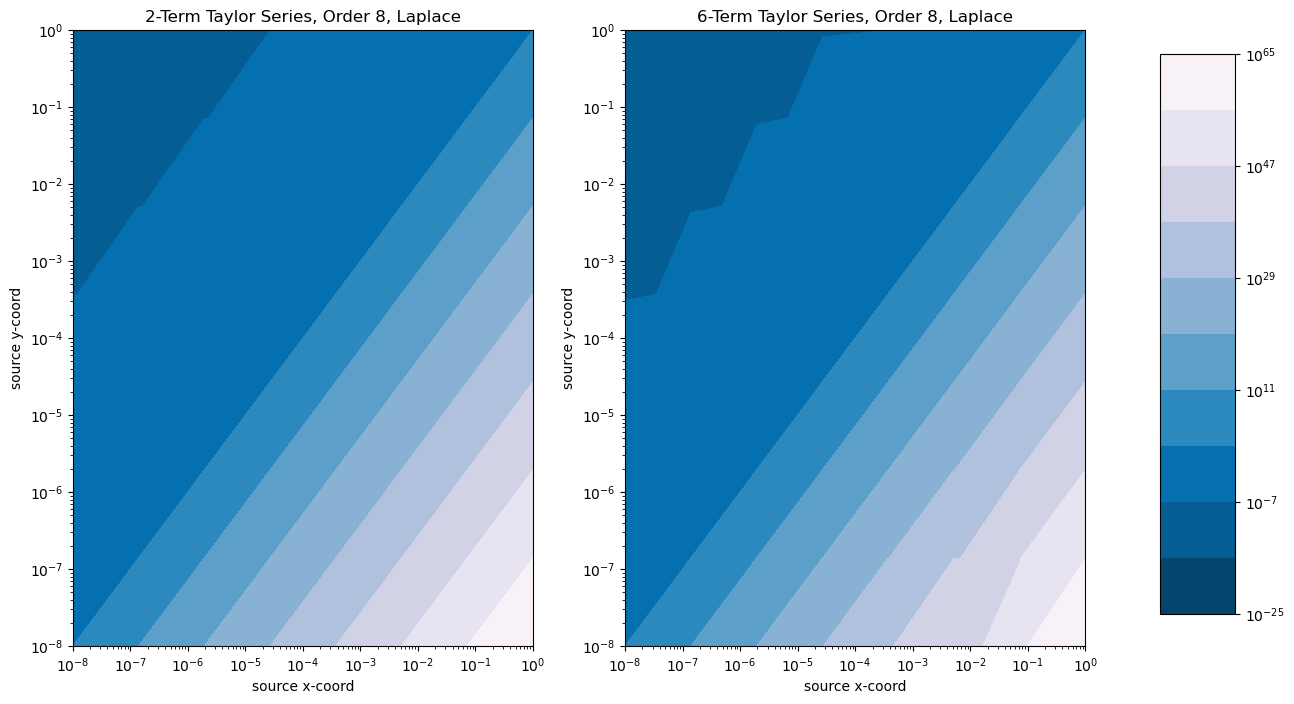

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
cs1 = ax1.contourf(x_grid, y_grid, plot_me_lap1.T, locator=ticker.LogLocator(), cmap=cm.PuBu_r)

cs2 = ax2.contourf(x_grid, y_grid, plot_me_lap2.T, locator=ticker.LogLocator(), cmap=cm.PuBu_r)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(cs1, cax=cbar_ax)


ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("source x-coord")
ax1.set_ylabel("source y-coord")


ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("source x-coord")
ax2.set_ylabel("source y-coord")

ax1.set_title('2-Term Taylor Series, Order 8, Laplace')
ax2.set_title('6-Term Taylor Series, Order 8, Laplace')

plt.show()